# Imports

In [2]:
%matplotlib inline 

import os
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from astropy.table import Table
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import curve_fit
from functools import reduce

import model_flux_ratio as mfr
import pca

In [3]:
path = os.getcwd()

For our He abundance measurements, we have Storey's 2018 (S2018) hydrogen emissivities, calculated for log(ne)=0-5 and T=5000-25000 K, and Porter's 2013 (P2013) helium emissivities. From these two datasets and respective extrapolations/interpolations, we will try two methods of interpolating/extrapolating:

(1) do *only* a RectBivariateSpline on the existing data

(2) do a PCA, then RectBivariateSpline

and decide what is best for our Yp analysis.

# Hydrogen Emissivities

## PCA then RectBivariateSpline

### Functional form for the fit to emissivities

In [4]:
def functional_form(T, a, b, c, d):
    #emis = ( a - (b * np.log(T)**2) + (c * np.log(T)) + (d / np.log(T)) ) * T**-1
    
    # Need to use a polynomial (instead of our original modified polynomial above) to match
    # the polynomial fit that is going on in PCA
    emis = ( a + (b * np.log10(T)) + (c * np.log10(T)**2) + (d * np.log10(T)**3) )

    return emis

### Load data

In [6]:
hydrogen_emis_S2018 = Table.read(path+'/tables/hydrogen_emissivity_S2018', format='ascii', delimiter='\t')

### Temperature and density range for fit

In [6]:
# T=5000-25000, matched to the S2018 temperature grid
temps = np.arange(5000, 26000, 1000)
print (temps, len(temps))

# Density array, matched to the S2018 density grid
dens = np.array([0,1,2,3,4,5])
print (dens, len(dens))

[ 5000  6000  7000  8000  9000 10000 11000 12000 13000 14000 15000 16000
 17000 18000 19000 20000 21000 22000 23000 24000 25000] 21
[0 1 2 3 4 5] 6


### Set up for PCA by calculating functional fit coefficients

In [7]:
# Empty arrays to save the coefficients of our functional form from scipy's curve_fit
# Our functional form has 4 coefficients: a, b, c, d and we will have one at each density value
# (i.e., at n_e = 100, there will be a, b, c, d; at n_e = 1000, there will be a, b, c, d)
ha_a_coeff = np.zeros(len(dens))
ha_b_coeff = np.zeros(len(dens))
ha_c_coeff = np.zeros(len(dens))
ha_d_coeff = np.zeros(len(dens))

hb_a_coeff = np.zeros(len(dens))
hb_b_coeff = np.zeros(len(dens))
hb_c_coeff = np.zeros(len(dens))
hb_d_coeff = np.zeros(len(dens))

hg_a_coeff = np.zeros(len(dens))
hg_b_coeff = np.zeros(len(dens))
hg_c_coeff = np.zeros(len(dens))
hg_d_coeff = np.zeros(len(dens))

hd_a_coeff = np.zeros(len(dens))
hd_b_coeff = np.zeros(len(dens))
hd_c_coeff = np.zeros(len(dens))
hd_d_coeff = np.zeros(len(dens))

h8_a_coeff = np.zeros(len(dens))
h8_b_coeff = np.zeros(len(dens))
h8_c_coeff = np.zeros(len(dens))
h8_d_coeff = np.zeros(len(dens))

pg_a_coeff = np.zeros(len(dens))
pg_b_coeff = np.zeros(len(dens))
pg_c_coeff = np.zeros(len(dens))
pg_d_coeff = np.zeros(len(dens))

In [8]:
# Loop through density values for which we have data
for dens_val in range(len(dens)):
    # Find indices in hydrogen_emissivity_S2018 and pull the emissivity values at those indices
    s2018_ha = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 3)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]
    s2018_hb = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 4)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]
    s2018_hg = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 5)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]
    s2018_hd = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]
    s2018_h8 = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 8)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]
    s2018_pg = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 3)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]

    # Fit a functional form to our new extrapolated emissivities
    popta, pcova = curve_fit(functional_form, temps, s2018_ha)
    ha_a_coeff[dens_val] = popta[0]
    ha_b_coeff[dens_val] = popta[1]
    ha_c_coeff[dens_val] = popta[2]
    ha_d_coeff[dens_val] = popta[3]
     
    poptb, pcovb = curve_fit(functional_form, temps, s2018_hb)
    hb_a_coeff[dens_val] = poptb[0]
    hb_b_coeff[dens_val] = poptb[1]
    hb_c_coeff[dens_val] = poptb[2]
    hb_d_coeff[dens_val] = poptb[3]
    
    poptg, pcovg = curve_fit(functional_form, temps, s2018_hg)
    hg_a_coeff[dens_val] = poptg[0]
    hg_b_coeff[dens_val] = poptg[1]
    hg_c_coeff[dens_val] = poptg[2]
    hg_d_coeff[dens_val] = poptg[3]
    
    poptd, pcovd = curve_fit(functional_form, temps, s2018_hd)
    hd_a_coeff[dens_val] = poptd[0]
    hd_b_coeff[dens_val] = poptd[1]
    hd_c_coeff[dens_val] = poptd[2]
    hd_d_coeff[dens_val] = poptd[3]
    
    popt8, pcov8 = curve_fit(functional_form, temps, s2018_h8)
    h8_a_coeff[dens_val] = popt8[0]
    h8_b_coeff[dens_val] = popt8[1]
    h8_c_coeff[dens_val] = popt8[2]
    h8_d_coeff[dens_val] = popt8[3]
    
    poptpg, pcovpg = curve_fit(functional_form, temps, s2018_pg)
    pg_a_coeff[dens_val] = poptpg[0]
    pg_b_coeff[dens_val] = poptpg[1]
    pg_c_coeff[dens_val] = poptpg[2]
    pg_d_coeff[dens_val] = poptpg[3]
    

### PCA starts here

In [9]:
import importlib
importlib.reload(pca)
importlib.reload(mfr)

<module 'model_flux_ratio' from '/Users/thsyu/Software/Yp/model_flux_ratio.py'>

In [10]:
# Create a 2D grid of log10(temperatures) so we can create a 2D grid of emissivities at these values:
#    -- densities -->
#   |
# temperatures
#  |
#  v

temps_arr = np.log10(np.repeat(temps, dens.size).reshape(21,6))

ha_emis_at_td = np.zeros((6,21))
hb_emis_at_td = np.zeros((6,21))
hg_emis_at_td = np.zeros((6,21))
hd_emis_at_td = np.zeros((6,21))
h8_emis_at_td = np.zeros((6,21))
pg_emis_at_td = np.zeros((6,21))

for i in range(dens.size):
    ha_emis_at_td[i] = functional_form(temps, ha_a_coeff[i], ha_b_coeff[i], ha_c_coeff[i], ha_d_coeff[i])
    hb_emis_at_td[i] = functional_form(temps, hb_a_coeff[i], hb_b_coeff[i], hb_c_coeff[i], hb_d_coeff[i])
    hg_emis_at_td[i] = functional_form(temps, hg_a_coeff[i], hg_b_coeff[i], hg_c_coeff[i], hg_d_coeff[i])
    hd_emis_at_td[i] = functional_form(temps, hd_a_coeff[i], hd_b_coeff[i], hd_c_coeff[i], hd_d_coeff[i])
    h8_emis_at_td[i] = functional_form(temps, h8_a_coeff[i], h8_b_coeff[i], h8_c_coeff[i], h8_d_coeff[i])
    pg_emis_at_td[i] = functional_form(temps, pg_a_coeff[i], pg_b_coeff[i], pg_c_coeff[i], pg_d_coeff[i])

ha_emis_arr = np.dstack((ha_emis_at_td[0], ha_emis_at_td[1], ha_emis_at_td[2], ha_emis_at_td[3], ha_emis_at_td[4], ha_emis_at_td[5]))[0]
hb_emis_arr = np.dstack((hb_emis_at_td[0], hb_emis_at_td[1], hb_emis_at_td[2], hb_emis_at_td[3], hb_emis_at_td[4], hb_emis_at_td[5]))[0]
hg_emis_arr = np.dstack((hg_emis_at_td[0], hg_emis_at_td[1], hg_emis_at_td[2], hg_emis_at_td[3], hg_emis_at_td[4], hg_emis_at_td[5]))[0]
hd_emis_arr = np.dstack((hd_emis_at_td[0], hd_emis_at_td[1], hd_emis_at_td[2], hd_emis_at_td[3], hd_emis_at_td[4], hd_emis_at_td[5]))[0]
h8_emis_arr = np.dstack((h8_emis_at_td[0], h8_emis_at_td[1], h8_emis_at_td[2], h8_emis_at_td[3], h8_emis_at_td[4], h8_emis_at_td[5]))[0]
pg_emis_arr = np.dstack((pg_emis_at_td[0], pg_emis_at_td[1], pg_emis_at_td[2], pg_emis_at_td[3], pg_emis_at_td[4], pg_emis_at_td[5]))[0]

ha_coeffs = np.stack((ha_a_coeff, ha_b_coeff, ha_c_coeff, ha_d_coeff))
hb_coeffs = np.stack((hb_a_coeff, hb_b_coeff, hb_c_coeff, hb_d_coeff))
hg_coeffs = np.stack((hg_a_coeff, hg_b_coeff, hg_c_coeff, hg_d_coeff))
hd_coeffs = np.stack((hd_a_coeff, hd_b_coeff, hd_c_coeff, hd_d_coeff))
h8_coeffs = np.stack((h8_a_coeff, h8_b_coeff, h8_c_coeff, h8_d_coeff))
pg_coeffs = np.stack((pg_a_coeff, pg_b_coeff, pg_c_coeff, pg_d_coeff))

ofit = np.array([1,1,1,1])
lnpc = len(ofit) - 1
dens_arr = dens


#### PypeIt's call to PCA, for reference to what the variables mean

In [11]:
ha_fitted, ha_outpar = pca.basis(temps_arr, ha_emis_arr, ha_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hb_fitted, hb_outpar = pca.basis(temps_arr, hb_emis_arr, hb_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hg_fitted, hg_outpar = pca.basis(temps_arr, hg_emis_arr, hg_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hd_fitted, hd_outpar = pca.basis(temps_arr, hd_emis_arr, hd_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
h8_fitted, h8_outpar = pca.basis(temps_arr, h8_emis_arr, h8_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
pg_fitted, pg_outpar = pca.basis(temps_arr, pg_emis_arr, pg_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)


Reduced chi-squared = 5.551288E-07
Reduced chi-squared = 1.777605E-06
Reduced chi-squared = 7.129338E-07
Reduced chi-squared = 2.809743E-07
Reduced chi-squared = 1.107642E-07
Reduced chi-squared = 8.131921E-11


### PCA interpolation (using pca.extrapolate())

In [11]:
refined_ne_array = np.arange(0, 5.5, 0.5)
print (refined_ne_array)

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


In [13]:
S2018_ha_extfit, ha_outpar2 = pca.extrapolate(ha_outpar, refined_ne_array)
S2018_hb_extfit, hb_outpar2 = pca.extrapolate(hb_outpar, refined_ne_array)
S2018_hg_extfit, hg_outpar2 = pca.extrapolate(hg_outpar, refined_ne_array)
S2018_hd_extfit, hd_outpar2 = pca.extrapolate(hd_outpar, refined_ne_array)
S2018_h8_extfit, h8_outpar2 = pca.extrapolate(h8_outpar, refined_ne_array)
S2018_pg_extfit, pg_outpar2 = pca.extrapolate(pg_outpar, refined_ne_array)

In [14]:
pca.pca_plot(ha_outpar, ofit, 'S2018_pca_1111_ha')
pca.pca_plot(hb_outpar, ofit, 'S2018_pca_1111_hb')
pca.pca_plot(hg_outpar, ofit, 'S2018_pca_1111_hg')
pca.pca_plot(hd_outpar, ofit, 'S2018_pca_1111_hd')
pca.pca_plot(h8_outpar, ofit, 'S2018_pca_1111_h8')
pca.pca_plot(pg_outpar, ofit, 'S2018_pca_1111_pg')

<Figure size 640x480 with 0 Axes>

### Write PCA-interpolated (onto a finer density grid) emissivities

In [ ]:
S2018_densinterp = open('hydrogen_emissivity_storey2018_densityPCAinterp', 'w')
for i in range(len(refined_ne_array)):
    for t in range(len(temps)):
        S2018_densinterp.write('3 2 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_ha_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        S2018_densinterp.write('4 2 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_hb_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        S2018_densinterp.write('5 2 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_hg_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        S2018_densinterp.write('6 2 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_hd_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        S2018_densinterp.write('8 2 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_h8_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        S2018_densinterp.write('6 3 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_pg_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        
S2018_densinterp.close()

### Plot PCA-interpolated emissivities

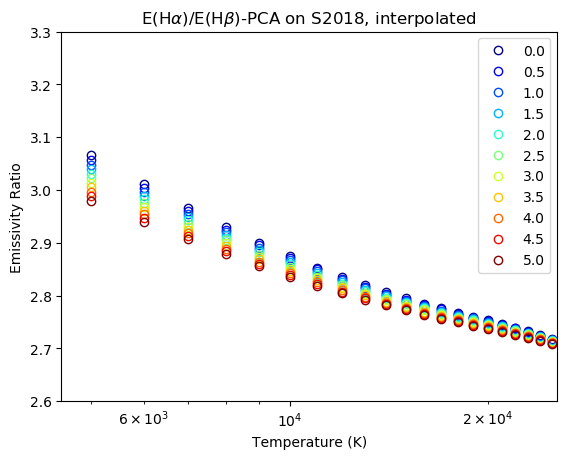

In [15]:
color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(refined_ne_array)):
    leg_label = str(refined_ne_array[i]) #+ ', PCA'
    plt.plot(temps, S2018_ha_extfit.T[i]/S2018_hb_extfit.T[i], label=leg_label, marker='o', linestyle='None', fillstyle='none', color=color[i])
plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-PCA on S2018, interpolated')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.3)
plt.xscale('log')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/S2018_PCA_interp.pdf', overwrite=True)
plt.show()

### Now do RBS on the PCA interpolations

In [8]:
S2018_temps = np.arange(5000, 26000, 1000)
refined_T_array = np.arange(5000, 26000, 500)

S2018_dens = np.arange(0,6) # log(ne)=0-5

In [18]:
S2018_ha_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_ha_extfit, kx=3, ky=3)
S2018_hb_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_hb_extfit, kx=3, ky=3)
S2018_hg_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_hg_extfit, kx=3, ky=3)
S2018_hd_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_hd_extfit, kx=3, ky=3)
S2018_h8_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_h8_extfit, kx=3, ky=3)
S2018_pg_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_pg_extfit, kx=3, ky=3)


### Plot PCA then RBS emissivities

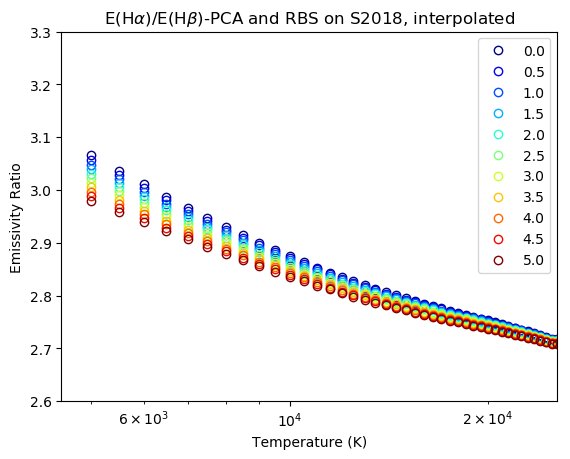

In [77]:
color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(refined_ne_array)):
    leg_label = str(refined_ne_array[i]) #+ ', PCA'
    plt.plot(refined_T_array, S2018_ha_PCAinterp(refined_T_array, refined_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, refined_ne_array[i]), label=leg_label, marker='o', linestyle='None', fillstyle='none', color=color[i])

plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-PCA and RBS on S2018, interpolated')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.3)
plt.xscale('log')
plt.legend()
plt.show()

### Comparison between PCA+RBS emissivities versus original S2018 values

The PCA emissivities do not necessarily go through the initial data points, so it's important to check how well we reproduce the emissivities at those grids

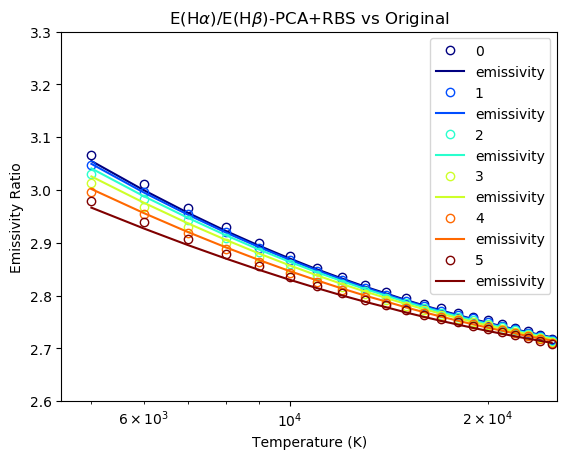

In [76]:
color = cm.jet(np.linspace(0,1,len(dens)))

for i in range(len(dens)):
    leg_label = str(dens[i]) #+ ', PCA'
    plt.plot(temps, S2018_ha_PCAinterp(temps, dens[i])/S2018_hb_PCAinterp(temps, dens[i]), label=leg_label, marker='o', linestyle='None', fillstyle='none', color=color[i])
    plt.plot(temps, (hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, \
                     (np.where(hydrogen_emis_S2018['Nu'] == 3)[0], \
                      np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                      np.where(hydrogen_emis_S2018['log(ne)'] == dens[i])))]) / \
                    (hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d,
                     (np.where(hydrogen_emis_S2018['Nu'] == 4)[0], \
                      np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                      np.where(hydrogen_emis_S2018['log(ne)'] == dens[i])))]) , color=color[i])

plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-PCA+RBS vs Original')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.3)
plt.xscale('log')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/S2018_PCARBS_vs_OG.pdf', overwrite=True)
plt.show()

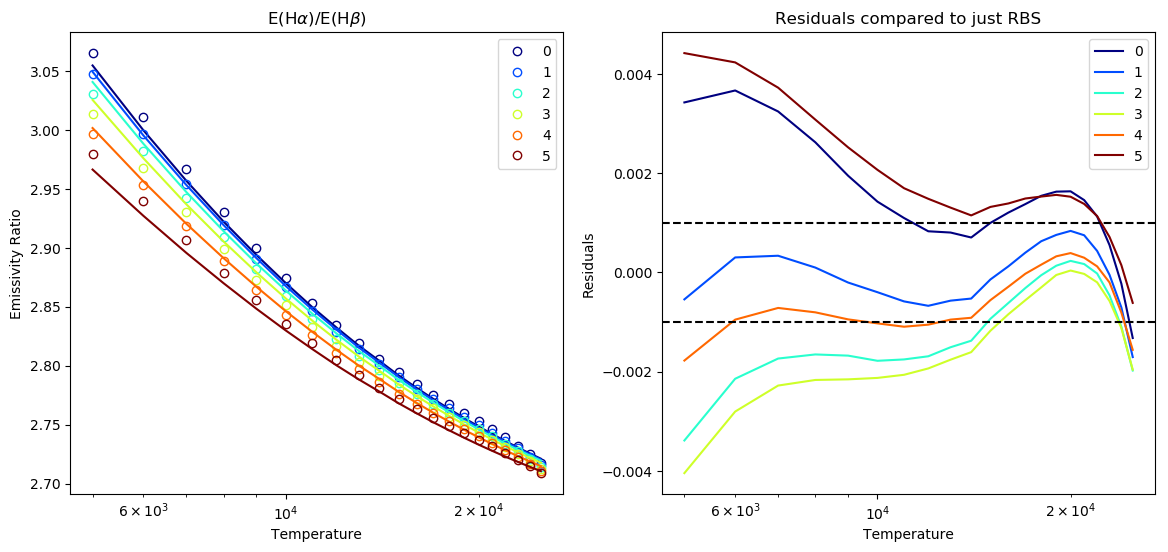

In [106]:
# Open .pdf to save emissivity and residual plots in
RBS_ha_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/PCAvsOG_halpha.pdf')

ha_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(dens)))

for i in range(len(dens)):
    orig_ha = (hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, \
                     (np.where(hydrogen_emis_S2018['Nu'] == 3)[0], \
                      np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                      np.where(hydrogen_emis_S2018['log(ne)'] == dens[i])))]) / \
          (hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d,
                     (np.where(hydrogen_emis_S2018['Nu'] == 4)[0], \
                      np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                      np.where(hydrogen_emis_S2018['log(ne)'] == dens[i])))])
    leg_label = str(dens[i]) #+ ', PCA'
    ax1.plot(temps, S2018_ha_PCAinterp(temps, dens[i])/S2018_hb_PCAinterp(temps, dens[i]), label=leg_label, marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(temps, orig_ha, color=color[i], label='_nolegend_')
    ax2.plot(temps, ((S2018_ha_PCAinterp(temps, dens[i])/S2018_hb_PCAinterp(temps, dens[i])).reshape(-1)-(orig_ha))/(orig_ha), label=dens[i], color=color[i])


ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\alpha$)/E(H$\beta$)')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to just RBS')
ax2.legend()

plt.show()
RBS_ha_pdf.savefig(ha_f)
RBS_ha_pdf.close()


## Just RectBivariateSpline

In [9]:
# Get S2018 emissivities into the right 21x6 format (temps, densities)
#  --- log10(density) --->
#  | (5000,0) (5000,1) ... (5000,5)
#  | (6000,0)
# temp ...
# | (25000,0)
# v
ha_RBS = np.zeros((21,6))
hb_RBS = np.zeros((21,6))
hg_RBS = np.zeros((21,6))
hd_RBS = np.zeros((21,6))
h8_RBS = np.zeros((21,6))
pg_RBS = np.zeros((21,6))

for t in range(len(S2018_temps)):
    ha_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 3)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]
    hb_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 4)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]
    hg_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 5)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]
    hd_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 6)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]
    h8_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 8)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]
    pg_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 6)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 3)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]

In [15]:
S2018_ha_interp_cubic = RectBivariateSpline(S2018_temps, S2018_dens, ha_RBS, kx=3, ky=3)
S2018_hb_interp_cubic = RectBivariateSpline(S2018_temps, S2018_dens, hb_RBS, kx=3, ky=3)
S2018_hg_interp_cubic = RectBivariateSpline(S2018_temps, S2018_dens, hg_RBS, kx=3, ky=3)
S2018_hd_interp_cubic = RectBivariateSpline(S2018_temps, S2018_dens, hd_RBS, kx=3, ky=3)
S2018_h8_interp_cubic = RectBivariateSpline(S2018_temps, S2018_dens, h8_RBS, kx=3, ky=3)
S2018_pg_interp_cubic = RectBivariateSpline(S2018_temps, S2018_dens, pg_RBS, kx=3, ky=3)

S2018_ha_interp_lin = RectBivariateSpline(S2018_temps, S2018_dens, ha_RBS, kx=1, ky=1)
S2018_hb_interp_lin = RectBivariateSpline(S2018_temps, S2018_dens, hb_RBS, kx=1, ky=1)
S2018_hg_interp_lin = RectBivariateSpline(S2018_temps, S2018_dens, hg_RBS, kx=1, ky=1)
S2018_hd_interp_lin = RectBivariateSpline(S2018_temps, S2018_dens, hd_RBS, kx=1, ky=1)
S2018_h8_interp_lin = RectBivariateSpline(S2018_temps, S2018_dens, h8_RBS, kx=1, ky=1)
S2018_pg_interp_lin = RectBivariateSpline(S2018_temps, S2018_dens, pg_RBS, kx=1, ky=1)

### Plot RBS interpolated emissivities

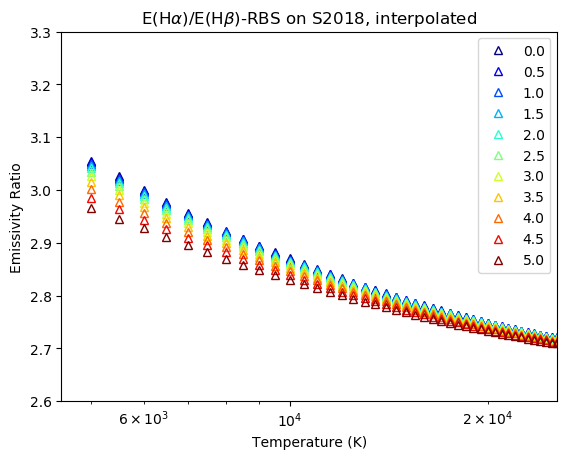

In [30]:
color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(refined_ne_array)):
    leg_label = str(refined_ne_array[i]) #+ ', PCA'
    plt.plot(refined_T_array, S2018_ha_interp(refined_T_array, refined_ne_array[i])/S2018_hb_interp(refined_T_array, refined_ne_array[i]), label=leg_label, marker='^', linestyle='None', fillstyle='none', color=color[i])
plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-RBS on S2018, interpolated')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.3)
plt.xscale('log')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/S2018_RBS_interp.pdf', overwrite=True)
plt.show()

### Comparison between linear and cubic RBS

Because RBS will always go through the initial data points, a more meaningful comparison is how the interpolated values differ at shifted temperature and density grids depending on the interpolation used (linear or cubic).

In [68]:
shift_T_array = np.arange(5250, 26000, 500)
shift_ne_array = np.arange(0.25, 5, 0.5)

#print (shift_T_array, shift_ne_array)

In [61]:
ha_RBS_diff = (S2018_ha_interp_lin(shift_T_array, shift_ne_array) - S2018_ha_interp_cubic(shift_T_array, shift_ne_array)) / S2018_h8_interp_cubic(shift_T_array, shift_ne_array)
    

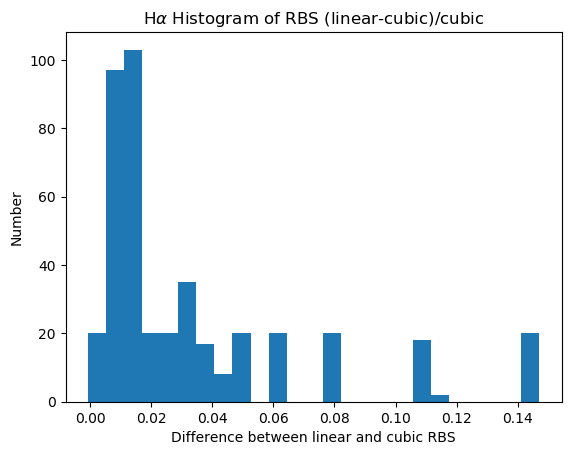

In [67]:
plt.hist(ha_RBS_diff.reshape(-1), 25)
plt.xlabel('Difference between linear and cubic RBS')
plt.ylabel('Number')
plt.title(r'H$\alpha$ Histogram of RBS (linear-cubic)/cubic')
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/RBS_linear_vs_cubic.pdf', overwrite=True)
plt.show()

# Comparison Plot!!!!

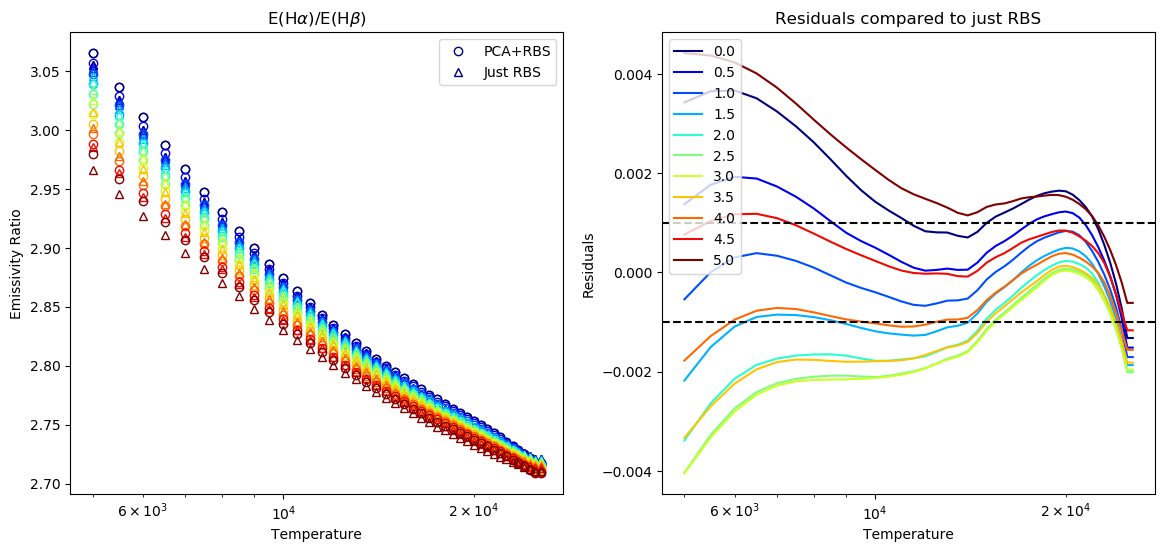

In [107]:
# Open .pdf to save emissivity and residual plots in
#RBS_ha_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/methods_comp_halpha.pdf')

ha_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(refined_ne_array)):
    ax1.plot(refined_T_array, S2018_ha_PCAinterp(refined_T_array, refined_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, refined_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_ha_interp(refined_T_array, refined_ne_array[i])/S2018_hb_interp(refined_T_array, refined_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((S2018_ha_PCAinterp(refined_T_array, refined_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, refined_ne_array[i]))-(S2018_ha_interp(refined_T_array, refined_ne_array[i])/S2018_hb_interp(refined_T_array, refined_ne_array[i])))/(S2018_ha_interp(refined_T_array, refined_ne_array[i])/S2018_hb_interp(refined_T_array, refined_ne_array[i])), \
            color=color[i], label=str(refined_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, S2018_ha_PCAinterp(refined_T_array, refined_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, refined_ne_array[i]), label='PCA+RBS', marker='o', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_ha_interp(refined_T_array, refined_ne_array[i])/S2018_hb_interp(refined_T_array, refined_ne_array[i]), label='Just RBS', marker='^', linestyle='None', fillstyle='none', color=color[i])


ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\alpha$)/E(H$\beta$)')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to just RBS')
ax2.legend()

plt.show()
#RBS_ha_pdf.savefig(ha_f)
#RBS_ha_pdf.close()
